In [1]:
# Import packages 
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

import requests
from IPython.display import Image
import pandas as pd

In [2]:
# Load data
df = pd.read_csv('data/incomes.txt', names=['income'])

In [3]:
incomes = df['income']
incomes.describe()

count       200.000000
mean      85276.823606
std       18037.692869
min       47628.560636
25%       71850.308175
50%       83864.444560
75%       96059.995074
max      139079.351549
Name: income, dtype: float64

## Problem 1.a

Plot the sample data. 

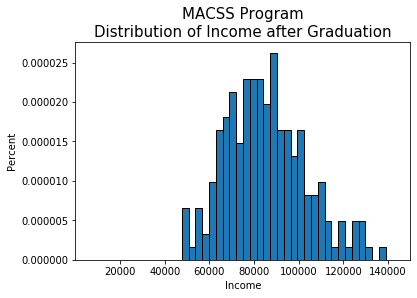

In [4]:
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])
plt.show()

## Problem 1.b

GMM
- R (No. of moment conditions): 2 
- Moment conditions
    - mean
    - standard deviation
- Weighting matrix: identity matrix

In [5]:
# Define a function that generates values of a lognormal pdf

def trunc_lognorm_pdf(x_vals, mu, sigma, cut_lb='None', cut_ub='None'):
    
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_lb)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_ub)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_ub) -
                       sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_lb))
            
    pdf_vals =  sts.lognorm(sigma, scale=np.exp(mu)).pdf(x_vals) / prob_notcut
    
    return pdf_vals

In [6]:
# Define the functions that calculate 
# data and model moment, the error vector, and the criterion

def data_moments(xvals):

    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


def model_moments(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):

    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [7]:
# Perfom GMM with R = 2, W = I
mu_init = 11
sig_init = 0.5
cut_lb = 0.0
cut_ub = 150000.0
params_init = np.array([mu_init, sig_init])
W_hat1_2 = np.eye(2)
gmm_args = (incomes, cut_lb, cut_ub, W_hat1_2)
results1_2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1_2, sig_GMM1_2 = results1_2.x
print('mu_GMM1 =', mu_GMM1_2, ' sig_GMM1 =', sig_GMM1_2)
results1_2

mu_GMM1 = 11.333533482547038  sig_GMM1 = 0.21386191435240276


      fun: array([[6.35762063e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.12689752e-08, -2.93697904e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33353348,  0.21386191])

In [8]:
# Print the result
print('mu_GMM1_2 =', mu_GMM1_2, ' sig_GMM1_2 =', sig_GMM1_2)
print()
print('Sample Mean = ', data_moments(incomes)[0])
print('Model Mean = ', model_moments(mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub)[0])
print()
print('Sample Variation = ', data_moments(incomes)[1])
print('Model Variation = ', model_moments(mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub)[1])
print()
print('Error vector = ',  err_vec(incomes, mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub, simple=False).reshape(2))
print()
print('Value of GMM criterion function at the estimated parameter = ', results1_2.fun)

mu_GMM1_2 = 11.333533482547038  sig_GMM1_2 = 0.21386191435240276

Sample Mean =  85276.82360625808
Model Mean =  85276.82405894245

Sample Variation =  18037.692869371564
Model Variation =  18037.692424756944

Error vector =  [ 5.30841031e-09 -2.46491956e-08]

Value of GMM criterion function at the estimated parameter =  [[6.35762063e-16]]


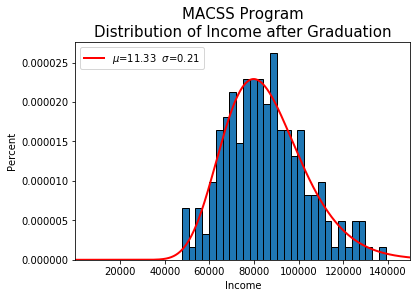

In [9]:
# Plot the estimated lognormal PDF against the data

# data histogram
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])

# pdf plot
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={round(mu_GMM1_2, 2)}  $\sigma$={round(sig_GMM1_2, 2)}')
plt.legend(loc='upper left')
plt.show()

## Problem 1.c

Two-step GMM
- R (No. of moment conditions): 2 
- Moment conditions
    - mean
    - standard deviation
- Weighting matrix: $\hat{\Omega}_{2step}$

In [10]:
# Define a functions that computes the R x N matrix of errors 
# from each observation for each moment. 
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_data, var_data = data_moments(pts)
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    
    return Err_mat

In [11]:
# Calculate the Variance Covariance Matrix of error from the first GMM 
# and the 2 step optimal Weighting Matrix
Err_mat = get_Err_mat2(incomes, mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub, simple=False)
VCV2 = (1 / incomes.shape[0]) * (Err_mat @ Err_mat.T)
print('Variance Covariance Matrix: \n', VCV2)
W_hat2_2 = lin.inv(VCV2)
print('Weighting Matrix: \n', W_hat2_2)

Variance Covariance Matrix: 
 [[4.45167060e-02 1.67963797e+03]
 [1.67963797e+03 9.49413425e+08]]
Weighting Matrix: 
 [[ 2.40701669e+01 -4.25833101e-05]
 [-4.25833101e-05  1.12861743e-09]]


In [12]:
# Perform GEE with R = 2, W = VCV^-1
mu_init = mu_GMM1_2
sig_init = sig_GMM1_2
cut_lb = 0.0
cut_ub = 150000.0
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, cut_lb, cut_ub, W_hat2_2)
results2_2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2_2, sig_GMM2_2 = results2_2.x
results2_2

      fun: array([[4.27941556e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.85931287e-08, -1.86302418e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
   status: 0
  success: True
        x: array([11.33353347,  0.21386191])

In [13]:
# Print the result
print('mu_GMM2_2 =', mu_GMM2_2, ' sig_GMM2_2 =', sig_GMM2_2)
print()
print('Sample Mean = ', data_moments(incomes)[0])
print('Model Mean = ', model_moments(mu_GMM2_2, sig_GMM2_2, cut_lb, cut_ub)[0])
print()
print('Sample Variation = ', data_moments(incomes)[1])
print('Model Variation = ', model_moments(mu_GMM2_2, sig_GMM2_2, cut_lb, cut_ub)[1])
print()
print('Error vector = ',  err_vec(incomes, mu_GMM2_2, sig_GMM2_2, cut_lb, cut_ub, simple=False).reshape(2))
print()
print('Value of GMM criterion function at the estimated parameter = ', results2_2.fun)

mu_GMM2_2 = 11.333533472755567  sig_GMM2_2 = 0.21386191374148164

Sample Mean =  85276.82360625808
Model Mean =  85276.82324668269

Sample Variation =  18037.692869371564
Model Variation =  18037.692248481504

Error vector =  [-4.21656647e-09 -3.44218113e-08]

Value of GMM criterion function at the estimated parameter =  [[4.27941556e-16]]


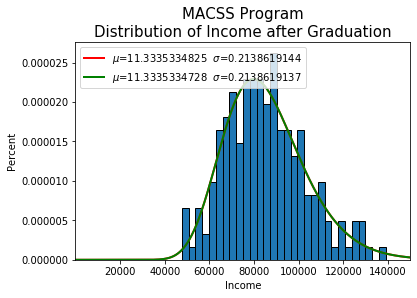

In [14]:
# Plot the estimated lognormal PDF against the data

# data histogram
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])

# pdf plot for GMM1 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={round(mu_GMM1_2, 10)}  $\sigma$={round(sig_GMM1_2, 10)}')

# pdf plot for GMM2 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM2_2, sig_GMM2_2, cut_lb, cut_ub),
         linewidth=2, color='g', label=f'$\mu$={round(mu_GMM2_2, 10)}  $\sigma$={round(sig_GMM2_2, 10)}')
plt.legend(loc='upper left')
plt.show()

The estimation is very close to that of the previous estimation. 

## Problem 1.d

GMM 
- R (No. of moment conditions): 4
- Moment conditions: percentiles
- Weighting matrix: the identity matrix

In [15]:
# Define the functions that calculate 
# data and model moment, the error vector, and the criterion

def data_moments3(xvals):

    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma, cut_lb, cut_ub):
 
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
 
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion3(params, *args):
   
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [16]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (incomes, cut_lb, cut_ub, W_hat1_3)
results1_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results1_3.x
results1_3

      fun: array([[4.29649541e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.32742779e-06,  3.97876860e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 102
      nit: 20
   status: 0
  success: True
        x: array([11.33670511,  0.21151358])

In [17]:
# Print the result
print('mu_GMM2_3 =', mu_GMM1_3, ' sig_GMM2_3 =', sig_GMM1_3)
print()
print('Percent of Individuals')
print('data moment %<75,000\n', data_moments3(incomes)[0])
print('model moment %<75,000\n', model_moments3(mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub)[0])
print()
print('data moment %>75,000, <100000\n', data_moments3(incomes)[1])
print('model moment %>75,000, <100000\n', model_moments3(mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub)[1])
print()
print('data moment %>100000\n', data_moments3(incomes)[2])
print('model moment %>100000\n', model_moments3(mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub)[2])
print()
print('Error vector = ',  err_vec3(incomes, mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub, simple=False).reshape(3))
print()
print('Value of GMM criterion function at the estimated parameter = ', results1_3.fun)

mu_GMM2_3 = 11.336705110695677  sig_GMM2_3 = 0.21151357584142724

Percent of Individuals
data moment %<75,000
 0.3
model moment %<75,000
 0.30000017045584526

data moment %>75,000, <100000
 0.5
model moment %>75,000, <100000
 0.499999868168341

data moment %>100000
 0.2
model moment %>100000
 0.19999996137581383

Error vector =  [ 5.68186151e-07 -2.63663318e-07 -1.93120931e-07]

Value of GMM criterion function at the estimated parameter =  [[4.29649541e-13]]


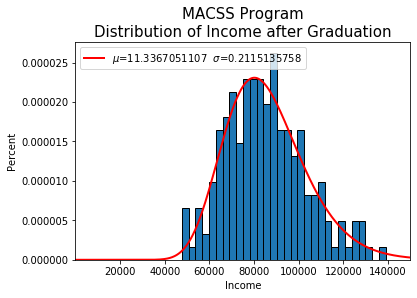

In [18]:
# Plot the estimated lognormal PDF against the data

# data histogram
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])

# pdf plot for GMM3 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={round(mu_GMM1_3, 10)}  $\sigma$={round(sig_GMM1_3, 10)}')
plt.legend(loc='upper left')
plt.show()

In [19]:
# Define a functions that computes the R x N matrix of errors 
# from each observation for each moment. 
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):

    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = (pts >= 100000)
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = (pts >= 100000)
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [20]:
# Calculate the Variance Covariance Matrix of error from the first GMM 
# and the 2 step optimal Weighting Matrix
Err_mat3 = get_Err_mat3(incomes, mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub, simple=True)
VCV2_3 = (1 / incomes.shape[0]) * (Err_mat3 @ Err_mat3.T)
print('Variance Covariance Matrix: \n', VCV2_3)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3)
print('Weighting Matrix: \n', W_hat2_3)

Variance Covariance Matrix: 
 [[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]
Weighting Matrix: 
 [[7.08816663e+14 7.08816663e+14 7.08816663e+14]
 [7.08816663e+14 7.08816663e+14 7.08816663e+14]
 [7.08816663e+14 7.08816663e+14 7.08816663e+14]]


In [21]:
mu_init = mu_GMM1_3
sig_init = sig_GMM1_3
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, cut_lb, cut_ub, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
results2_3

      fun: array([[0.01330858]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.05783096e+07, 1.02550834e+08])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 132
      nit: 1
   status: 2
  success: False
        x: array([11.33670505,  0.21151357])

In [22]:
# Print the result
print('mu_GMM2_3 =', mu_GMM2_3, ' sig_GMM2_3 =', sig_GMM2_3)
print()
print('Percent of Individuals')
print('data moment %<75,000\n', data_moments3(incomes)[0])
print('model moment %<75,000\n', model_moments3(mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub)[0])
print()
print('data moment %>75,000, <100000\n', data_moments3(incomes)[1])
print('model moment %>75,000, <100000\n', model_moments3(mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub)[1])
print()
print('data moment %>100000\n', data_moments3(incomes)[2])
print('model moment %>100000\n', model_moments3(mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub)[2])
print()
print('Error vector = ',  err_vec3(incomes, mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub, simple=False).reshape(3))
print()
print('Value of GMM criterion function at the estimated parameter = ', results2_3.fun)

mu_GMM2_3 = 11.336705046719254  sig_GMM2_3 = 0.21151357464779277

Percent of Individuals
data moment %<75,000
 0.3
model moment %<75,000
 0.3000002738885024

data moment %>75,000, <100000
 0.5
model moment %>75,000, <100000
 0.4999998492840883

data moment %>100000
 0.2
model moment %>100000
 0.19999987682740925

Error vector =  [ 9.12961675e-07 -3.01431823e-07 -6.15862954e-07]

Value of GMM criterion function at the estimated parameter =  [[0.01330858]]


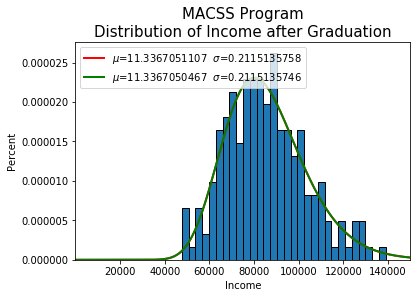

In [23]:
# Plot the estimated lognormal PDF against the data

# data histogram
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])

# pdf plot for GMM1_3 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={round(mu_GMM1_3, 10)}  $\sigma$={round(sig_GMM1_3, 10)}')

# pdf plot for GMM2_3 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub),
         linewidth=2, color='g', label=f'$\mu$={round(mu_GMM2_3, 10)}  $\sigma$={round(sig_GMM2_3, 10)}')
plt.legend(loc='upper left')
plt.show()

## Problem 1.f

In [24]:
mu_GMM_list = [mu_GMM1_2, mu_GMM2_2, mu_GMM1_3, mu_GMM2_3]
sig_GMM_list = [sig_GMM1_2, sig_GMM2_2, sig_GMM1_3, sig_GMM2_3]
fun_list = [results1_2.fun, results2_2.fun, results1_3.fun, results2_3.fun]
pd.DataFrame(data={"mu_GMM":mu_GMM_list, 
              "sigma_GMM":sig_GMM_list, 
              "Criterion function value": fun_list}, 
             index=['R=2 identity', 
                    'R=2 2step', 
                    'R=3 identity', 
                    'R=3 2step']).astype(float)

,mu_GMM,sigma_GMM,Criterion function value
R=2 identity,11.333533,0.213862,6.357621e-16
R=2 2step,11.333533,0.213862,4.279416e-16
R=3 identity,11.336705,0.211514,4.296495e-13
R=3 2step,11.336705,0.211514,1.330858e-02


The 2-step GMM model that uses 2 moment conditions has the smallest value of the criterion function. It fits the data the best in a sense that the sum of squared error is the smallest. 

# Problem 2

## Problem 2.1

In [25]:
reg_data = pd.read_csv("data/sick.txt").astype('float64')
reg_data['constant'] = 1
reg_data.head()

,sick,age,children,avgtemp_winter,constant
0,1.67,57.47,3.04,54.10,1
1,0.71,26.77,1.20,36.54,1
2,1.39,41.85,2.31,32.38,1
3,1.37,51.27,2.46,52.94,1
4,1.45,44.22,2.72,45.90,1


In [26]:
y_vals = reg_data['sick']
x_matrix = np.array(reg_data[['constant', 'age', 'children', 'avgtemp_winter']])

In [27]:
def reg_data_moment(y_vals): 
    return y_vals


def reg_model_moment(x_matrix, beta_array): 
    return x_matrix @ beta_array


def reg_err_vec(y_vals, x_matrix, beta_array): 
    err_vec = y_vals - reg_model_moment(x_matrix, beta_array)
    return err_vec
    
def reg_criterion(beta_array, *args): 
    y_vals, x_matrix, W = args
    err_vec = reg_err_vec(y_vals, x_matrix, beta_array)
    return err_vec.T @ W @ err_vec

In [28]:
beta_init = 0, 0, 0, 0
params_init = np.array([beta_init])
W_hat_reg = np.eye(200)
gmm_args = (y_vals, x_matrix, W_hat_reg)
results_reg = opt.minimize(reg_criterion, params_init, args=(gmm_args))
beta0, beta1, beta2, beta3 = results_reg.x
results_reg

      fun: 0.0018212896800919721
 hess_inv: array([[ 0.05280017,  0.00043398, -0.00904355, -0.00119908],
       [ 0.00043398,  0.0002267 , -0.00202797, -0.00014215],
       [-0.00904355, -0.00202797,  0.0208239 ,  0.00128675],
       [-0.00119908, -0.00014215,  0.00128675,  0.0001096 ]])
      jac: array([-5.39998437e-05,  1.43805082e-04, -1.46396444e-04,  5.16662316e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 480
      nit: 4
     njev: 78
   status: 2
  success: False
        x: array([ 0.2516443 ,  0.01293358,  0.40049986, -0.00999176])

In [29]:
print('Estimation Result: \n')
print('VARIABLES', ' ' * 6, 'GNN Estimation')
print('-'*40)
i = 0
beta_print = [beta1, beta2, beta3, beta0]
for column_name, column_data in reg_data[['age', 'children', 'avgtemp_winter', 'constant']].iteritems(): 
    print(column_name, ' ' * (15 - len(column_name)), beta_print[i], '\n')
    i += 1

print('Criterion Function Value (SSE): ', - results_reg.fun)

Estimation Result: 

VARIABLES        GNN Estimation
----------------------------------------
age              0.012933582649980412 

children         0.400499861340649 

avgtemp_winter   -0.009991760472725274 

constant         0.2516442992222972 

Criterion Function Value (SSE):  -0.0018212896800919721
